# Trying XGB Model

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.xgb_model import XGB_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Define features

These are the features i used in the model

In [2]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

# XGB cannot handle categorical features
base_features =  (    raw_bool_features              
#                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                       )

label = 'fraud_ind'

# Preprocess

In [3]:
preprocess_group = False
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [45]:
# One hot encoding
df_dummies = pd.get_dummies(df, columns=['contp','stscd','etymd','hcefg','stocn','csmcu'])
df_train, df_test = preprocess_train_test_split(df_dummies, cat_features = ['bacno'])
input_features = base_features + list(df_dummies.loc[:,'contp_1':].columns)
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4,etymd_0,etymd_1,etymd_2,etymd_3,etymd_4,etymd_5,etymd_6,etymd_7,etymd_8,etymd_9,etymd_10,hcefg_0,hcefg_1,hcefg_2,hcefg_3,hcefg_4,hcefg_5,hcefg_6,hcefg_7,hcefg_8,hcefg_9,stocn_0,stocn_1,stocn_2,stocn_3,stocn_4,stocn_5,stocn_6,stocn_7,stocn_8,stocn_9,stocn_10,stocn_11,stocn_12,stocn_13,stocn_14,stocn_15,stocn_16,stocn_17,stocn_18,stocn_19,stocn_20,stocn_21,stocn_22,stocn_23,stocn_24,stocn_25,stocn_26,stocn_27,stocn_28,stocn_29,stocn_30,stocn_31,stocn_32,stocn_33,stocn_34,stocn_35,stocn_36,stocn_37,stocn_38,stocn_39,stocn_40,stocn_41,stocn_42,stocn_43,stocn_44,stocn_45,stocn_46,stocn_47,stocn_48,stocn_49,stocn_50,stocn_51,stocn_52,stocn_53,stocn_54,stocn_55,stocn_56,stocn_57,stocn_58,stocn_59,stocn_60,stocn_61,stocn_62,stocn_63,stocn_64,stocn_65,stocn_66,stocn_67,stocn_68,stocn_69,stocn_70,stocn_71,stocn_72,stocn_73,stocn_74,stocn_75,stocn_76,stocn_77,stocn_78,stocn_79,stocn_80,stocn_81,stocn_82,stocn_83,stocn_84,stocn_85,stocn_86,stocn_87,stocn_88,stocn_89,stocn_90,stocn_91,stocn_92,stocn_93,stocn_94,stocn_95,stocn_96,stocn_97,stocn_98,stocn_99,stocn_100,stocn_101,stocn_102,stocn_103,stocn_104,stocn_105,stocn_106,stocn_107,stocn_108,csmcu_0,csmcu_1,csmcu_2,csmcu_3,csmcu_4,csmcu_5,csmcu_6,csmcu_7,csmcu_8,csmcu_9,csmcu_10,csmcu_11,csmcu_12,csmcu_13,csmcu_14,csmcu_15,csmcu_16,csmcu_17,csmcu_18,csmcu_19,csmcu_20,csmcu_21,csmcu_22,csmcu_23,csmcu_24,csmcu_25,csmcu_26,csmcu_27,csmcu_28,csmcu_29,csmcu_30,csmcu_31,csmcu_32,csmcu_33,csmcu_34,csmcu_35,csmcu_36,csmcu_37,csmcu_38,csmcu_39,csmcu_40,csmcu_41,csmcu_42,csmcu_43,csmcu_44,csmcu_45,csmcu_46,csmcu_47,csmcu_48,csmcu_49,csmcu_50,csmcu_51,csmcu_52,csmcu_53,csmcu_54,csmcu_55,csmcu_56,csmcu_57,csmcu_58,csmcu_59,csmcu_60,csmcu_61,csmcu_62,csmcu_63,csmcu_64,csmcu_65,csmcu_66,csmcu_67,csmcu_68,csmcu_69,csmcu_70,csmcu_71,csmcu_72,csmcu_73,csmcu_74,csmcu_75
1943429,0,0,0,0,0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1943430,1,0,0,0,0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1943431,0,0,0,0,0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1943432,0,0,0,0,0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0

# Base Model

In [46]:
xgb = XGB_Model(input_features)
xgb.build_clf()
oof_preds_LGBM, df_sub_preds_LGBM, clf = xgb.run(X_train, y_train, groups, X_test, xgb.xgb_averge_precision, n_splits = 10)


Starting LightGBM. Fold 1,Train shape: (1521787, 238), test shape: (421665, 238)
Multiple eval metrics have been passed: 'validation_1-Averge_Precision' will be used for early stopping.

Will train until validation_1-Averge_Precision hasn't improved in 100 rounds.
[0]	validation_0-Averge_Precision:0.639468	validation_1-Averge_Precision:0.499504
[100]	validation_0-Averge_Precision:0.81698	validation_1-Averge_Precision:0.636595
[200]	validation_0-Averge_Precision:0.866491	validation_1-Averge_Precision:0.650485
[300]	validation_0-Averge_Precision:0.894038	validation_1-Averge_Precision:0.654965
[400]	validation_0-Averge_Precision:0.913046	validation_1-Averge_Precision:0.656691
Stopping. Best iteration:
[379]	validation_0-Averge_Precision:0.909748	validation_1-Averge_Precision:0.657646

Starting LightGBM. Fold 2,Train shape: (1521787, 238), test shape: (421665, 238)
Multiple eval metrics have been passed: 'validation_1-Averge_Precision' will be used for early stopping.

Will train until val

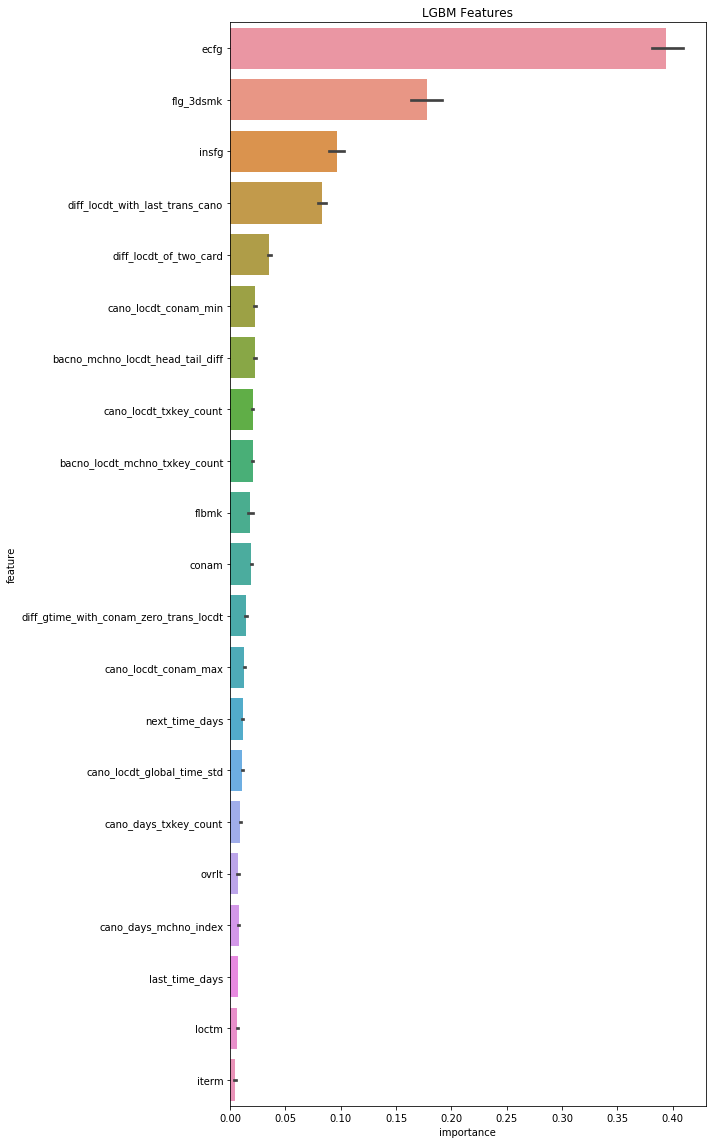

In [7]:
plot_importance(xgb.df_feature_importance)

In [47]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics.head(10)

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,max,min,std,mean,upper_bound_1std,lower_bound_1std
0,0.000298,0.000273,0.000485,0.000255,0.000391,0.000327,0.000162,0.000262,0.000286,0.000326,0.000485,0.000162,0.000082,0.000307,0.000388,0.000225
1,0.000222,0.000146,0.000143,0.000302,0.000212,0.000138,0.000118,0.000196,0.000140,0.000217,0.000302,0.000118,0.000054,0.000183,0.000237,0.000130
2,0.000086,0.000384,0.000235,0.000273,0.000213,0.000198,0.000203,0.000217,0.000206,0.000194,0.000384,0.000086,0.000070,0.000221,0.000291,0.000151
3,0.000351,0.000217,0.000239,0.000445,0.000289,0.000319,0.000418,0.000467,0.000400,0.000354,0.000467,0.000217,0.000080,0.000350,0.000430,0.000269
4,0.000099,0.000092,0.000088,0.000074,0.000096,0.000109,0.000091,0.000090,0.000068,0.000165,0.000165,0.000068,0.000025,0.000097,0.000122,0.000072
5,0.000044,0.000071,0.000072,0.000089,0.000067,0.000057,0.000051,0.000085,0.000073,0.000083,0.000089,0.000044,0.000014,0.000069,0.000083,0.000055
6,0.000038,0.000042,0.000044,0.000059,0.000081,0.000059,0.000025,0.000057,0.000033,0.000039,0.000081,0.000025,0.000015,0.000048,0.000063,0.000032
7,0.000193,0.000807,0.000451,0.000693,0.000643,0.000432,0.000382,0.000570,0.000570,0.000744,0.000807,0.000193,0.000177,0.000549,0.000726,0.000372
8,0.000034,0.000038,0.000029,0.000054,0.000023,0.000024,0.000037,0.000028,0.000023,0.000040,0.000054,0.000023,0.000009,0.000033,0.000042,0.000024
9,0.000376,0.000645,0.000757,0.000519,0.000510,0.000465,0.000359,0.000424,0.000566,0.000520,0.000757,0.000359,0.000115,0.000514,0.000629,0.000399


In [48]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9].head(10)

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,max,min,std,mean,upper_bound_1std,lower_bound_1std


# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [49]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']].head(10)

,mean,mean_remove_outlier


In [50]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Find the range of threshold which maximizes the f1 score

In [51]:
for i in range(0,70):
    print (i, f1_score(y_train, np.where(df_train['oof_base_model']>i/100,1,0) ))

0 0.026398347233912316
1 0.3080338334899699
2 0.389307571161306
3 0.44509444251648406
4 0.48523014459129143
5 0.5173469387755101
6 0.542970936835202
7 0.5641328164503624
8 0.5816170122799909
9 0.5960134345794393
10 0.6069544906570223
11 0.6173677069199458
12 0.6260143198090693
13 0.6324563900296832
14 0.6387273633493935
15 0.6448265638897124
16 0.6504875312796617
17 0.6552223099184425
18 0.6595167104267723
19 0.6631163263003498
20 0.6669259454141978
21 0.6699123661148978
22 0.6727204467595851
23 0.6747417171357322
24 0.6773015567941573
25 0.6795653970491724
26 0.6813235402490849
27 0.6830720381027982
28 0.6837859504960417
29 0.6847334226559143
30 0.6852163277786271
31 0.6863057324840766
32 0.6867494824016562
33 0.6871005608451807
34 0.6876215505913272
35 0.6883570710012178
36 0.6875466467640473
37 0.6875134206570753
38 0.6879173763754832
39 0.6875816282107097
40 0.6873066710465084
41 0.6870317320405465
42 0.6863446135084948
43 0.6852311727447753
44 0.6838767607609855
45 0.6831015710941

## Create Submission

Use different models to predict based on different condiitons. Change the threshold to create submission. 

In [63]:
threshold = 0.28

df_test['fraud_ind'] = np.where(df_sub_preds_LGBM.mean(axis = 1)> threshold, 1, 0)

df_test[['txkey','fraud_ind']].to_csv('result/sub_xgb_{}.csv'.format(threshold),index = False)